In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from pathlib import Path
import pandas as pd

In [3]:
#path = Path('/home/ubuntu/data/autopsy/milestone/no_preprocessing')

path = Path('/home/ubuntu/data/autopsy/2014_2018/no_preprocessing/reports/k-fold-suicide-homicide-accident-natural')


In [4]:
df = pd.read_csv(path/'data_suicide_homicide_accident_natural_k_1.csv')
df.head()

,label,text,is_valid
0,Accident,\n.MICRO.\nHEART: Scattered myofibers are enla...,False
1,Accident,\n.MICRO.\nHeart: negative\n\nLungs: mild emph...,False
2,Accident,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYBlunt i...,False
3,Accident,\n.MICRO.\nBrain: No significant histopatholog...,False
4,Accident,"\n.MICRO.\nLIVER: Cirrhosis present, characte...",False


In [5]:
df['text'][1]

'\n.MICRO.\nHeart: negative\n\nLungs: mild emphysema; autolysis\n\nLiver: fatty change; autolysis\n\nKidney: autolysis\n\nThyroid: negative\n\nEsophagus: autolysis\n.LOCATIONExtremity\n.INJURYBlunt injury.\n.INJURYDESC.\nThere is an 8 x 4 cm area of discontinuous abrasions overlying the left knee.\n\n.LOCATIONBack\n.INJURYBlunt injury.\n.INJURYDESC.\nThere is a 4 x 2 cm irregular pressure abrasion overlying the lumbar spine.\n\nThere is a 3 x 1.5 cm pressure abrasion on the lower left buttock.'

In [6]:
bs=32

In [7]:

classes = ['Suicide','Homicide','Accident','Natural']

In [8]:
valid_df =  df.loc[df['is_valid']==True]

In [9]:
train_df = df.loc[df['is_valid']==False]

In [10]:
data_lm = TextLMDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, classes=classes,bs=bs)

In [11]:
data_lm.show_batch()

idx,text
0,"within the interstitium , predominantly around the airways . \n \n xxup liver : xxmaj rare microaggregates of mixed inflammatory cells ( lymphocytes , histiocytes , neutrophils ) are within the lobules . \n \n xxup kidney : xxmaj evaluation is limited by partial autolysis ; there are no significant , histopathologic abnormalities . \n .locationextremities \n .injuryblunt injury . \n xxup .injurydesc . \n"
1,"with the follicular xxunk of papillary carcinoma . \n .locationhead \n .injuryblunt injury . \n xxup .injurydesc . \n a 3.1 x 0.5 cm red , dried abrasion is under the right chin . \n \n .locationextremity \n .injuryillicit substance use . \n xxup .injurydesc . \n a 0.1 cm , fresh injection site is within the right antecubital fossa . \n"
2,to 3.2 cm . xxmaj the right preauricular region contains a 5.0 cm red abrasion . xxmaj the right nostril contains two 0.5 cm red abrasions . xxmaj the lips are diffusely abraded and contused . xxmaj the top of the nose contains a 2.0 cm red abrasion . xxmaj the left maxillary region contains a 3.0 red abraded contusion . xxmaj the left lower eyelid contains a 5.0 cm
3,"giant cell granulomas of portal regions \n \n xxmaj kidney : mild arteriolonephrosclerosis \n \n xxmaj brain : negative \n .locationchest \n .injuryblunt injury . \n xxup .injurydesc . \n xxmaj resuscitation injuries : \n \n xxmaj rib fractures , anterolateral : 3,5 left , 4 - 6 right \n xxmaj small laceration of proximal superior vena cava with associated anterior mediastinal"
4,: \n \n xxmaj the parenchyma has a moderate degree of diffuse steatosis . xxmaj scattered portal tracts and lobules have a mild lymphoplasmacytic infiltrate with rare neutrophils . \n \n xxup kidney : \n \n xxmaj no significant histopathologic abnormalities . \n .locationtrunk \n .injuryblunt injury . \n xxup .injurydesc . \n a 1 x 0.5 cm red - brown crusted ovoid


In [12]:
learn = language_model_learner(data_lm, arch=AWD_LSTM)

In [13]:
learn.freeze()

In [14]:
#do some gradual unfreezing, so we don't lose the pretrained info
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,2.437959,2.096444,0.536422,01:12
2,2.338436,1.979499,0.554260,01:12


In [15]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.997764,1.800887,0.582271,01:14


In [16]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.867756,1.712542,0.598034,01:18


In [17]:
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.825038,1.685008,0.603211,01:24
2,1.719084,1.635645,0.612602,01:24
3,1.668741,1.582179,0.622237,01:24
4,1.536738,1.543075,0.630185,01:24
5,1.548387,1.512631,0.637338,01:24
6,1.454001,1.494126,0.641896,01:24
7,1.470712,1.484959,0.643523,01:24
8,1.410028,1.484465,0.643849,01:24


In [18]:
learn.save_encoder('fine_tuned_enc_no_pretrain2')

In [19]:
data_clas = TextClasDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, vocab=data_lm.train_ds.vocab, bs=bs, classes=classes)

In [20]:
data_clas.show_batch()

text,target
"xxbos \n xxup .micro . \n xxup heart : xxmaj myocyte hypertrophy , interstitial fibrosis \n \n xxup lungs : xxmaj peripherally dilated alveolar spaces with septal clubbing alternating with areas of atelectasis ; mild deposition of black pigment around bronchioles and pleura \n \n xxup kidneys : xxmaj frequent , globally sclerotic glomeruli ; patchy interstitial fibrosis ; patchy interstitial lymphocytic inflammation \n \n",Homicide
"xxbos \n xxup .micro . \n xxup brain : xxmaj no significant , histopathologic findings \n \n xxup heart : xxmaj no significant , histopathologic findings \n \n xxup lungs : xxmaj no significant , histopathologic findings \n \n xxup kidneys : xxmaj no significant , histopathologic findings \n \n xxup liver : xxmaj no significant , histopathologic findings \n \n \n .locationextremity",Homicide
"xxbos \n xxup .micro . \n xxup heart : no significant histopathologic diagnosis \n \n xxup lungs : patchy intra - alveolar fluid ; rare , variably polarizable material in large airways and in interstitial , vascular spaces often with a maltese - cross appearance and lack of significant inflammation ; mild , patchy interstitial and pleural chronic inflammation \n \n xxup liver : mild ,",Homicide
"xxbos \n xxup .micro . \n xxup none \n .locationhead \n .injuryblunt injury . \n xxup .injurydesc . \n 1 . xxup chop xxup wound xxup of xxup the xxup left xxup frontal xxup scalp ( xxup wound a ) \n \n xxmaj on the anterolateral inferior left frontal scalp , 6 cm below the top of the head and 6 cm left",Homicide
xxbos \n xxup .micro . \n xxup left xxup circumflex xxup coronary xxup artery - a partially xxunk thrombus is present within the lumen . xxmaj away from the thrombus there is focal atherosclerotic narrowing of the lumen estimated to be greater than 95 % . \n \n xxup lungs - xxmaj partially collapsed lung parenchyma with intra - alveolar blood and edema fluid . xxmaj there,Suicide


In [21]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.8)
learn.load_encoder('fine_tuned_enc_no_pretrain2')
learn.freeze()

In [22]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.887213,0.948806,0.645177,01:09


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.801940,0.889386,0.670383,01:27


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.731942,0.851005,0.684440,02:04


In [25]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(3e-4,3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.723508,0.876113,0.681047,02:21
2,0.716110,0.848219,0.680078,02:06
3,0.716712,0.768116,0.697528,02:09
4,0.713254,0.805197,0.691226,02:15
5,0.690591,0.828763,0.676200,02:18
6,0.721464,0.903891,0.696558,02:10
7,0.712360,0.776145,0.705768,02:16
8,0.694478,0.693945,0.698982,02:16
9,0.681129,0.722996,0.698982,02:26
10,0.685443,0.889476,0.692196,02:09


In [26]:
from fastai.vision import *

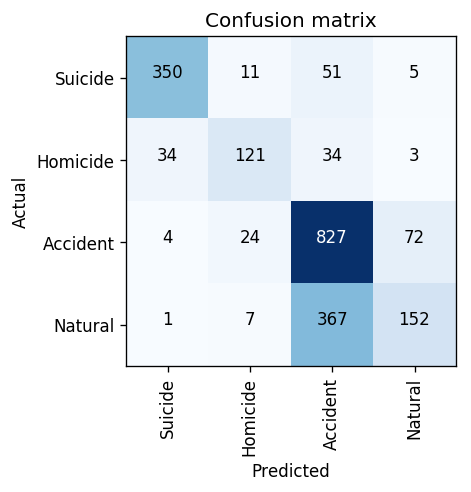

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

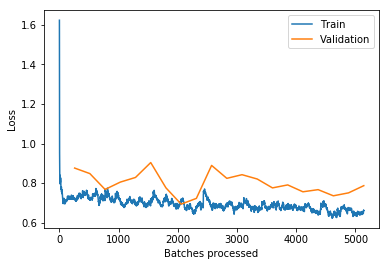

In [28]:
learn.recorder.plot_losses()

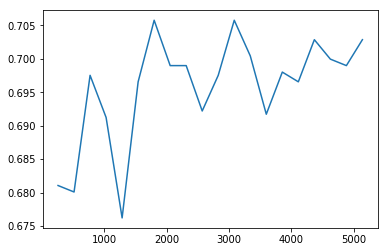

In [29]:
learn.recorder.plot_metrics()

In [30]:
def intrinsic_attention_modified_old(self, text:str, class_id:int=None):
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        self.model.train()
        self.model.zero_grad()
        self.model.reset()
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        self.model.zero_grad()
        self.model.reset()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn
    
def intrinsic_attention_modified(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)                
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max() 
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

def eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): eval_dropouts(module)

TextClassificationInterpretation.intrinsic_attention = intrinsic_attention_modified
ci = TextClassificationInterpretation.from_learner(learn)

In [31]:
import matplotlib.cm as cm

In [32]:
def interpret_result(row_index):
    example = df['text'][row_index]
    label = df['label'][row_index]
    print('True Label:',label)
    
    prediction_class = learn.predict(example)[0]
    prediction_probs = learn.predict(example)[2]
    
    print('\nPred Label:',prediction_class)
    print('\nClass Probabilities:',prediction_probs)
    
    print('\n***Raw Text***')
    print(example)
    
    print('\n***Intrinsic Attention***')
    
    ci.show_intrinsic_attention(example,  cmap=cm.Reds)
    
    prediction_class = learn.predict(example)[0]
    prediction_probs = learn.predict(example)[2]
    
    
    

In [33]:
interpret_result(13)

True Label: Accident

Pred Label: Accident

Class Probabilities: tensor([0.0385, 0.0201, 0.7635, 0.1778])

***Raw Text***

.MICRO.
Heart: Patchy left and right ventricular hypertrophy.

Lungs:  Scattered foci of septal clubbing and fragmentation. Scattered collections of intraalveolar macrophages. Colonies of postmortem bacterial overgrowth.

Liver: Moderate steatosis. Increased periportal chronic inflammation and chronic lobular inflammation. 

Kidney: Rare intratubular calcification.

Brain: No significant histopathologic diagnosis.
.LOCATIONOther
.INJURYBlunt injury.
.INJURYDESC.
Dried red linear oblique abrasion of right posterior proximal thigh, 1 x 3/8 inch.

Two parallel linear oblique scratch abrasions of left proximal thigh near the gluteal cleft (less than two inches in greatest dimension).

***Intrinsic Attention***


In [34]:
interpret_result(20)

True Label: Accident

Pred Label: Homicide

Class Probabilities: tensor([0.0030, 0.6569, 0.3375, 0.0026])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
4 inch purple-green contusion surrounding wound left temple closed with steri-strips with corresponding deep scalp bruise

large amount of bilateral bloody cerebral spinal fluid with small adherent subdural clot left temporal lobe and xanthochromic change, dura of right middle cranial fossa.

multifocal subarachnoid hemorrhage described in neuropathology report

.LOCATIONTrunk
.INJURYBlunt injury.
.INJURYDESC.
4 inch purple contusion left iliac crest

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
6 inch zone of purple-green contusion left wrist and dorsal left hand

***Intrinsic Attention***


In [35]:
interpret_result(107)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9986e-01, 1.1959e-30, 1.3689e-04, 8.3069e-08])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
Deformity superior to left brow 1.7 cm width x 0.7 cm height. 

.LOCATIONHead
.INJURYHanging.
.INJURYDESC.
Reddish-brown line across the left eyeball distal to the pupil. 

.LOCATIONHead
.INJURYHanging.
.INJURYDESC.
Petechiae noted to the left eye.

.LOCATIONNeck
.INJURYHanging.
.INJURYDESC.
Abrasion left side neck 5.5 cm width x 1.5 cm height

.LOCATIONNeck
.INJURYHanging.
.INJURYDESC.
Abrasion L upper neck 5.5 width x 2.5 cm height. 

.LOCATIONNeck
.INJURYHanging.
.INJURYDESC.
Abrasion right upper neck 4.5 cm width x 2.5 cm height. 

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
Abrasion, scabbed 0.5 cm width x 0.5 cm height to left lower leg medial and distal to patella

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
Abrasion, scabbed 0.5 cm width x 0.5 cm height to left lowe

In [36]:
interpret_result(117)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([8.8779e-01, 1.1220e-01, 6.7895e-06, 1.8691e-06])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Entrance: on the posterior left upper palate is an oblong 1.5 by 1.0 cm entrance gunshot wound without obvious soot deposition.

Path: upper palate, sella turcica, basal ganglia at the midline, medial cerebral hemispheres and impacts left medial superior parietal skull. Associated injuries include subarachnoid hemorrhage.

No exit

Recovery: recovered from the left superior parietal skull is a jacketed 228.4 grain moderately deformed bullet.

Trajectory:upwards and backwards

Hands: negatve

***Intrinsic Attention***


In [37]:
interpret_result(134)

True Label: Natural

Pred Label: Accident

Class Probabilities: tensor([0.0052, 0.3106, 0.6664, 0.0178])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
There are bilateral, blue-green, periorbital contusions and there is an avulsed laceration of the left scalp.

***Intrinsic Attention***


In [38]:
interpret_result(138)

True Label: Natural

Pred Label: Accident

Class Probabilities: tensor([0.0161, 0.2537, 0.5995, 0.1307])

***Raw Text***

.MICRO.
Heart: negative

Lungs: bronchopneumonia

Kidney: negative

Liver: severe fatty change with individual hepatic cell necrosis (alcoholic hepatitis)

Pancreas: acute pancreatitis

Adrenal: cortical hemorrhage


.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
On the left side of the forehead is a 0.8 x 0.5 cm abrasion in the middle of a raised 4 x 4 cm blue contusion.

There is extensive subscalpular contusion of the left side of the head most pronounced in the frontal and temporal areas.

There is bilateral healing periorbital contusion greater on the fright than the left.

On the right side of the face there is faint healing contusion that is a dependent continuation of the right periorbital contusion.

There are no internal head or brain injuries.

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
There is a 2 x 2 cm irregular abrasion surrounded by an 8 

In [39]:
interpret_result(10248)

True Label: Natural

Pred Label: Accident

Class Probabilities: tensor([0.0243, 0.0121, 0.5937, 0.3699])

***Raw Text***

.MICRO.
Heart:
Increase in interstitial fibrosis with focal replacement of myocardium; Patchy myocyte hypertrophy

Lungs:
Mild edema

Liver:
Mild macro- and microvesicular steatosis; portal bridging fibrosis and mild chronic portal inflammation

kidneys:
Nodular glomerulosclerosis (Kimmelstiel-Wilson nodules) and focal global glomerulosclerosis; arteriolosclerosis.

Hippocampus:
No pathologic abnormality.
.LOCATIONExtremities
.INJURYBlunt injury.
.INJURYDESC.
LEFT UPPER EXTREMITY

There are red dried abrasions of the left posterior forearm and lateral upper arm, ranging from 0.1 to 2.5 cm. 

RIGHT UPPER EXTREMITY

There is a 2.5 x 0.2 cm linear abrasion of the lateral right upper arm.

There are two, 1 cm and 2.5 cm, light purple to blue contusions of the right anterior upper arm.  

There is a 5 x 2.5 cm blue to purple contusion of the right antecubital fossa.

The

In [40]:
interpret_result(10252)

True Label: Natural

Pred Label: Accident

Class Probabilities: tensor([0.0080, 0.0731, 0.8928, 0.0261])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
There are possible contusions of the face; livor mortis is also very prominent in the face.

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
There are brown abrasions of the anterior, left knee.

***Intrinsic Attention***


In [41]:
interpret_result(10307)

True Label: Natural

Pred Label: Accident

Class Probabilities: tensor([0.0275, 0.0168, 0.5168, 0.4389])

***Raw Text***

.MICRO.
Kidney: Subnuclear renal tubular vacuoles (Armani-Ebstein change) in a background of tubular autolysis; focal glomerulosclerosis; arteriolosclerosis.

Liver: Marked steatosis with increased portal tract fibrosis, bridging fibrous septa and chronic periportal and septal inflammation.

Lungs: Focal areas of increased intra-alveolar eosinophilic granular material (pulmonary edema) and pigment laden macrophages. Rare focus of septal fibrosis.

Heart: Patchy left ventricular myocyte hypertrophy.

Pancreas: Irregular interlobular fibrosis without acute or chronic inflammation. 

Brain: No histopathologic diagnosis.

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
There is a single, 1cm, purple-black contusion on the right anterior forearm.  Additionally, a confluence of less than 1 cm ecchymoses is present on the left arm just below the shoulder.

.LOCATIONEx

In [42]:
interpret_result(10186)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0698, 0.8956, 0.0156, 0.0190])

***Raw Text***

.MICRO.
NONE
.LOCATIONTrunk
.INJURYFirearm injury.
.INJURYDESC.
GUNSHOT WOUND OF THE ANTERIOR RIGHT CHEST

Entrance:

On the anterior right chest, 48 cm below the top of the head, 6 cm right of the anterior midline, and 8 cm inferomedial to the right nipple, is an entrance gunshot wound consisting of a 0.5 cm round defect with a 0.7 x 0.7 cm dark red abrasion at the lateral edge of the defect.  Soot, unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound.

Path:

The hemorrhagic wound track sequentially perforates the skin and subcutaneous tissue of the anterior right and left side of the chest, the anterior 4th and 5th left ribs, the lateral 5th left intercostal space, and the skin and subcutaneous tissue of the lateral upper left chest.  

Associated injuries include a 2 x 0.5 cm linear, red abrasion of the paramidl

In [43]:
interpret_result(10279)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0111, 0.9825, 0.0023, 0.0040])

***Raw Text***

.MICRO.
BRAIN (left cerebellum) - No significant histopathology identified

HEART - No significant histopathology identified

LUNGS - Diffuse vascular and septal congestion with extensive parenchymal collapse

LIVER - No significant histopathology identified

KIDNEY - No significant histopathology identified
.LOCATIONAbdomen
.INJURYFirearm injury.
.INJURYDESC.
GUNSHOT WOUND OF THE ABDOMEN

Entrance:

On the upper, left abdomen, 58.0 cm below the top of the head and 7.5 cm left of the anterior midline, is an entrance gunshot wound consisting of a 1.0 x 0.9 cm, round defect with a 0.2 - 0.5 cm wide, circumferential, red marginal abrasion (widest at 7 - 11 and 3 - 5 o' clock) which is then surrounded by a 0.3 - 0.7 cm wide, partially circumferential, pink abrasion. Soot, unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the w

In [44]:
valid = df.loc[df['is_valid']==True]

In [45]:
valid

,label,text,is_valid
13,Accident,\n.MICRO.\nHeart: Patchy left and right ventri...,True
20,Accident,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYBlunt i...,True
23,Accident,"\n.MICRO.\nLung: Vegetable matter, fungal and ...",True
29,Accident,\n.MICRO.\nBRAIN: A section of the brain is wi...,True
32,Accident,\n.MICRO.\nADRENALS:\nLeft: Intraparechymal no...,True
45,Accident,\n.MICRO.\nHeart: left ventricular myocyte hyp...,True
50,Accident,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYBlunt i...,True
54,Accident,\n.MICRO.\nNONE\n.LOCATIONChest\n.INJURYBlunt ...,True
60,Accident,\n.MICRO.\nHeart: negative\n\nLiver: negative\...,True
76,Accident,"\n.MICRO.\nBRAIN: No significant, histopatholo...",True


In [46]:
'''for i in range(0,3040):
    example = df['text'][i]
    label = df['label'][i]
    val = df['is_valid'][i]
    prediction_class = learn.predict(example)[0]
    if str(label) != str(prediction_class):
        print(i, label, prediction_class, val)
'''

"for i in range(0,3040):\n    example = df['text'][i]\n    label = df['label'][i]\n    val = df['is_valid'][i]\n    prediction_class = learn.predict(example)[0]\n    if str(label) != str(prediction_class):\n        print(i, label, prediction_class, val)\n"